### Make required imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from sklearn.model_selection import train_test_split
from interpret import show
from interpret import data
from interpret.glassbox import ExplainableBoostingRegressor, LinearRegression, RegressionTree
from interpret.perf import RegressionPerf

warnings.filterwarnings("ignore")

### Load dataframe and separate feature and target sets

In [2]:
df = pd.read_pickle('COS_Seesaw_dataframe.pkl')
print(df)
columns = list(df.columns)
if 'COS_JFJ' in columns:
    columns.remove('COS_JFJ')
else:
    print('Error, target column not in dataframe')
    quit()
    
x = df[columns]
y = df['COS_JFJ']

           time  COS_JFJ     NH_sst     SH_sst  NH_sst-2m  SH_sst-2m
21   2000-03-02   447.77  11.830271  15.141506  12.369363  14.211244
22   2000-03-05   454.99  11.848338  15.112172  12.336472  14.296056
23   2000-03-06   450.81  11.855376  15.101149  12.321572  14.329835
24   2000-03-07   453.45  11.858768  15.081848  12.305551  14.371146
25   2000-03-11   451.90  11.862728  15.062534  12.221418  14.517519
...         ...      ...        ...        ...        ...        ...
1885 2018-09-26   437.56  15.888455  12.344624  15.698779  12.490609
1886 2018-09-27   438.04  15.837394  12.360606  15.747860  12.488142
1887 2018-09-28   433.50  15.800682  12.368045  15.801668  12.480263
1888 2018-09-29   443.24  15.764831  12.371663  15.844060  12.468072
1889 2018-09-30   437.52  15.745292  12.375092  15.878586  12.461205

[1869 rows x 6 columns]


### Make test train split, random seed is to ensure consistent results on multiple runs
### change  seed value to get different split

In [3]:
seed = 2
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=seed)

# set up for preicted vs actual plot
# sorting the test set should not matter since we are not using it to train
X_test = X_test.sort_index()
y_test = y_test.sort_index()
test_time = X_test['time']
X_test.drop(axis=1, labels='time', inplace=True)

#drop time in X_train
X_train.drop(axis=1, labels='time', inplace=True)

### Show Marginal

In [4]:
marginal = data.Marginal()
marginal_explanation = marginal.explain_data(X_train, y_train)
show(marginal_explanation)

<!-- http://127.0.0.1:7001/139831072248528/ -->

### Train Models

In [5]:
ebm = ExplainableBoostingRegressor(random_state=seed, interactions=3)
ebm.fit(X_train, y_train)

lr = LinearRegression(random_state=seed)
lr.fit(X_train, y_train)

rt = RegressionTree(random_state=seed)
rt.fit(X_train, y_train)

### What model learned

In [6]:
ebm_global = ebm.explain_global(name='EBM')
lr_global = lr.explain_global(name='Linear Regression')
rt_global = rt.explain_global(name='Regression Tree')

### Explanation of individul prediction

In [7]:
ebm_local = ebm.explain_local(X_test, y_test, name='EBM')
lr_local = lr.explain_local(X_test, y_test, name='Linear Regression')
rt_local = rt.explain_local(X_test, y_test, name='Regression Tree')

### Evaluate performance

In [8]:
ebm_perf = RegressionPerf(ebm.predict).explain_perf(X_test, y_test, name='EBM')
lr_perf = RegressionPerf(lr.predict).explain_perf(X_test, y_test, name='Linear Regression')
rt_perf = RegressionPerf(rt.predict).explain_perf(X_test, y_test, name='Regression Tree')

### Everything at once

In [9]:
show([marginal_explanation, lr_global, lr_perf, lr_local, rt_global, rt_perf, rt_local, ebm_global, ebm_perf, ebm_local])

<!-- http://127.0.0.1:7001/139830164438864/ -->
 Open in new window

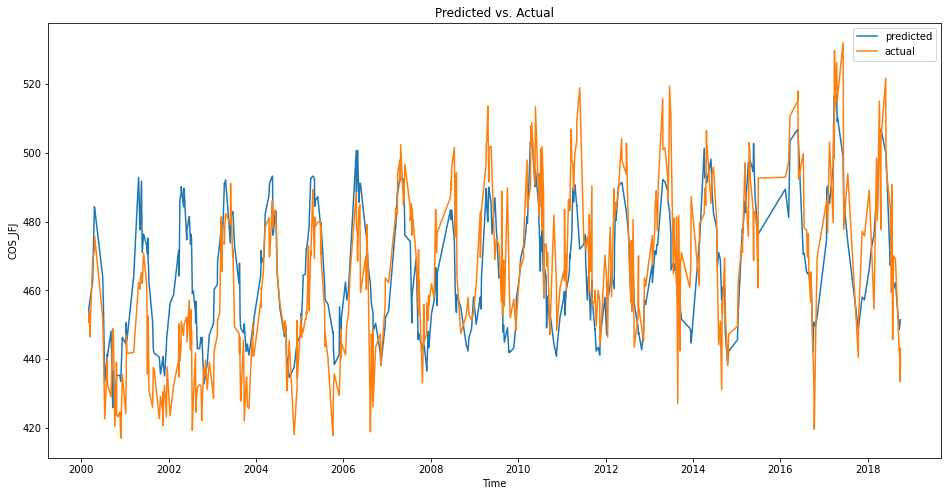

In [11]:
'''
predicted = ebm.predict(X_test)
fig, ax = plt.subplots(figsize=(8,8))
ax.scatter(y_test, predicted, label='predicted vs. actual')
ax.set_title("predicted vs. actual")
ax.set_xlabel("actual")
ax.set_ylabel("predicted")
ax.set_xlim([400, 550])
ax.set_ylim([400, 550])
ax.plot([0,1],[0,1], transform=ax.transAxes, ls='--', color='red')
plt.legend()
plt.show()
fig.savefig('predictedVsActual.png')
'''

predicted = ebm.predict(X_test)
fig, ax = plt.subplots(figsize=(16,8))
ax.plot(test_time, predicted, label='predicted')
ax.plot(test_time, y_test, label='actual')
ax.set_title("Predicted vs. Actual")
ax.set_xlabel('Time')
ax.set_ylabel('COS_JFJ')
plt.legend()
plt.show()
fig.savefig('predictedVsActualOverTime.png')